# Wasserhaushalt von Stadtbäumen - Urban Tree

In diesem Notebook wird die Anwendung des Urban-Tree Modells zur Modellierung des Wasserhaushalts von Stadtbäumen vorgestellt. Benötigt werden tägliche Zeitreihen des Niederschlags und der Evapotranspiration, sowie eine Vielzahl von Baumparametern.
In der Studie wurden Bäume "zufällig" erstellt, um eine Vielzahl von möglichen unterschiedlichen Parameterkombinationen zu berücksichtigen.
Der Beispieldatensatz basiert auf täglichen Beobachtungswerten von 2018-2022 der DWD-Station Potsdam (ID:3987). Der Niederschlag wurde nach der Methode von Kochendorfer korrigiert. Um den numerischen Fehler klein zu halten, wurde dieser tägliche Datensatz auf stündliche Daten heruntergerechnet (geteilt durch 24).

In [1]:
import pandas as pd
import urban_tree_model as ut
import numpy as np
import scipy
import matplotlib.pyplot as plt

data = pd.read_csv("example_data_potsdam.csv")
data.date = pd.to_datetime(data.date)

### Erstellung eines zufällig parametrisierten mittelalten Baumes

In [2]:
tree = ut.Tree("medium")

print(f"Bodenart in Pflanzgrube: {tree.soil}")
print(f"Effektive Wurzeltiefe: {tree.rooting_depth} m")
print(f"Kronenfläche: {tree.cpa} m²")
print(f"Bodenwassergehalt: {round(tree.saw, 1)} mm")
print(f"Infiltrationskoeffizient: {tree.c_inf} mm")
print(f"Pflanzenspezifischer Verdunstungskoeffizient: {tree.kc}")
print(f"Trockenstresskoeffizient: {round(tree.k_ea, 1)}")
print(f"Trockenstressfaktor: {round(tree.k_s, 1)}")
print(f"Feldkapazität: {tree.fc} mm")
print(f"Versiegelungsgrad: {tree.surface_sealing}")
print(f"Versiegelungsart: {tree.sealing_class}")
print(f"Sky-View-Factor: {tree.sky_view_factor}")
print(f"Anfansgwassergehalt: {tree.start_water_content}")

Bodenart in Pflanzgrube: fine_sandy
Effektive Wurzeltiefe: 1.0 m
Kronenfläche: 42 m²
Bodenwassergehalt: 12.8 mm
Infiltrationskoeffizient: 21 mm
Pflanzenspezifischer Verdunstungskoeffizient: 0.6
Trockenstresskoeffizient: 0.5
Trockenstressfaktor: 0.3
Feldkapazität: 178.0 mm
Versiegelungsgrad: 0.15
Versiegelungsart: 3
Sky-View-Factor: 1.08
Anfansgwassergehalt: 0.5


### Wasserhaushalt eines mittelalten Baums ohne Bewässerung
Zwecks Reproduzierbarkeit, wird hier ein fester Parametersatz gefällt. In der Studie wurden die Daten aus dem zufällig erstellten Baum übernommen (siehe oben) und optimiert.

In [3]:
df = ut.urban_tree(data.et_pot.values, data.rain_corrected.values, data.date.values,
                       l_max=10,
                       c_i=0.5,
                       c_r=0.2,
                       c_rt=10,
                       c_inf=21,
                       k_c=0.64,
                       k_ea=0.54,
                       k_s=0.3,
                       fc=200,
                       pwp=50,
                       crown_area=40,
                       surface_sealing=0.1,
                       sealing_class=4,
                       rooting_depth=1.25,
                       start_water_content=0.45,
                       cistern_volume=0,
                       cistern_catchment=0,
                       loss_factor_in=0.4,
                       loss_factor_out=0.2,
                       irrigation_rate=0,
                       sky_view_factor=1.34)

df.set_index("date", inplace=True)
daily_summed = df.resample('D').sum()
daily_mean = df.resample("D").mean()

et_a_daily = df.et_a_mm.resample("D").sum()
rain_daily = df.rain_mm.resample("D").sum()
swc_daily = df["soil_water_content_mm/m"].resample("D").mean()
water_stress_daily = df.water_stress.resample("D").sum().round(0)

trockentage = len(water_stress_daily.loc[water_stress_daily > 12])

print(f'Jährliches Mittel der Tage mit Trockenstress: {round(trockentage/5, 1)} Tage/Jahr')

Jährliches Mittel der Tage mit Trockenstress: 23.2 Tage/Jahr


#### Erstellung einer Abbildung

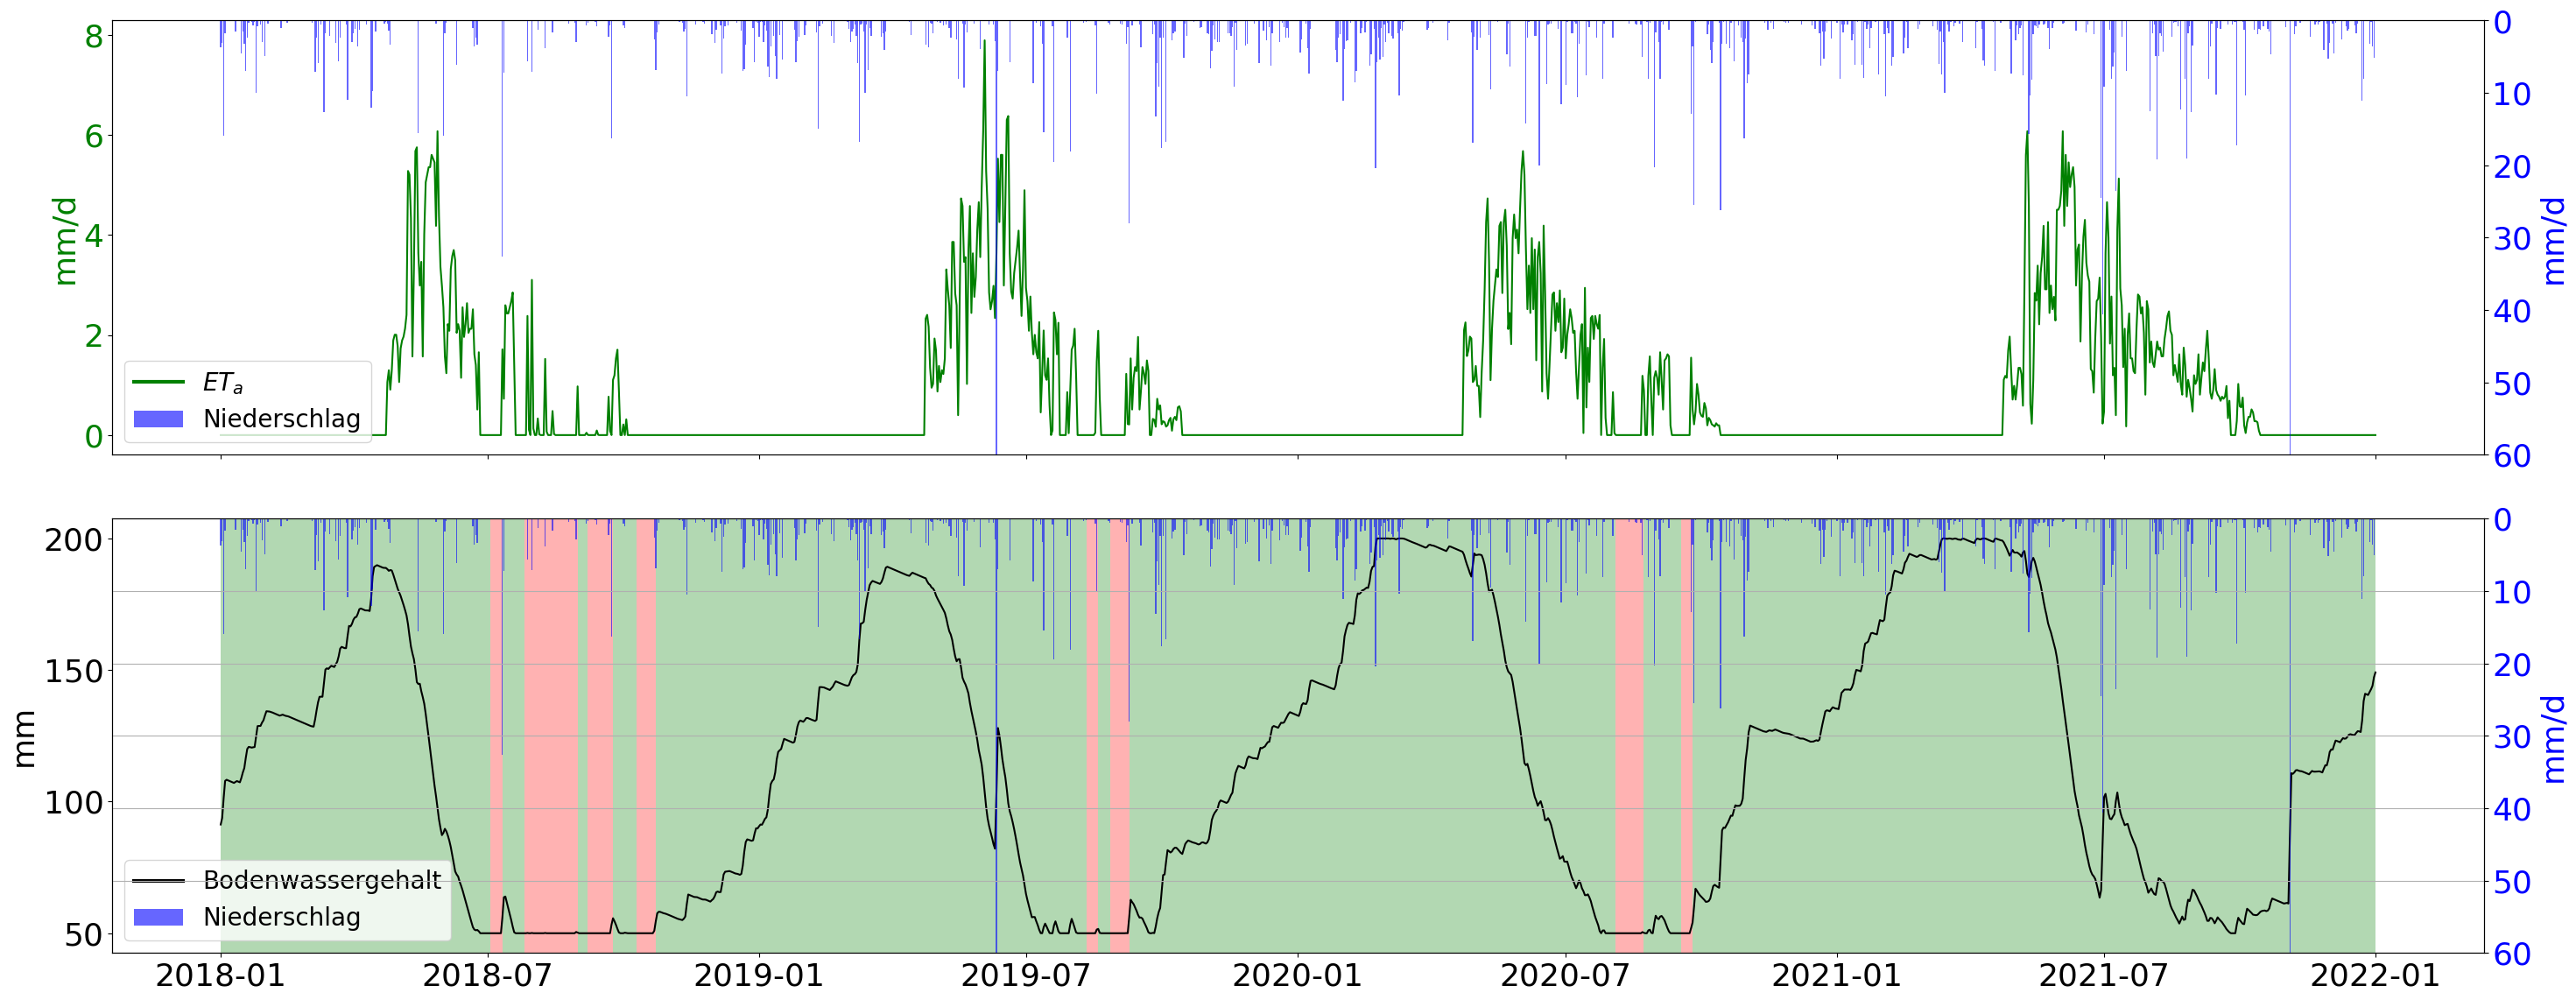

In [4]:
plt.rcParams.update({'font.size': 26 })
plot_df = pd.DataFrame({"rain":rain_daily, "et_a":et_a_daily, "soil_water_content":swc_daily,
                        "water_stress": water_stress_daily, "date":rain_daily.index})
ut.make_figure(plot_df)

### Wasserhaushalt des erstellten Baums mit Bewässerung mit ermittelten Zisternenkennwerten:
Zisternengröße: 155 l
Zisternenauffangfläche: 9.4 m²
Bewässerungsrate: 90l/Tag bei Wasserstress

Jährliches Mittel der Tage mit Trockenstress: 4.5 Tage/Jahr


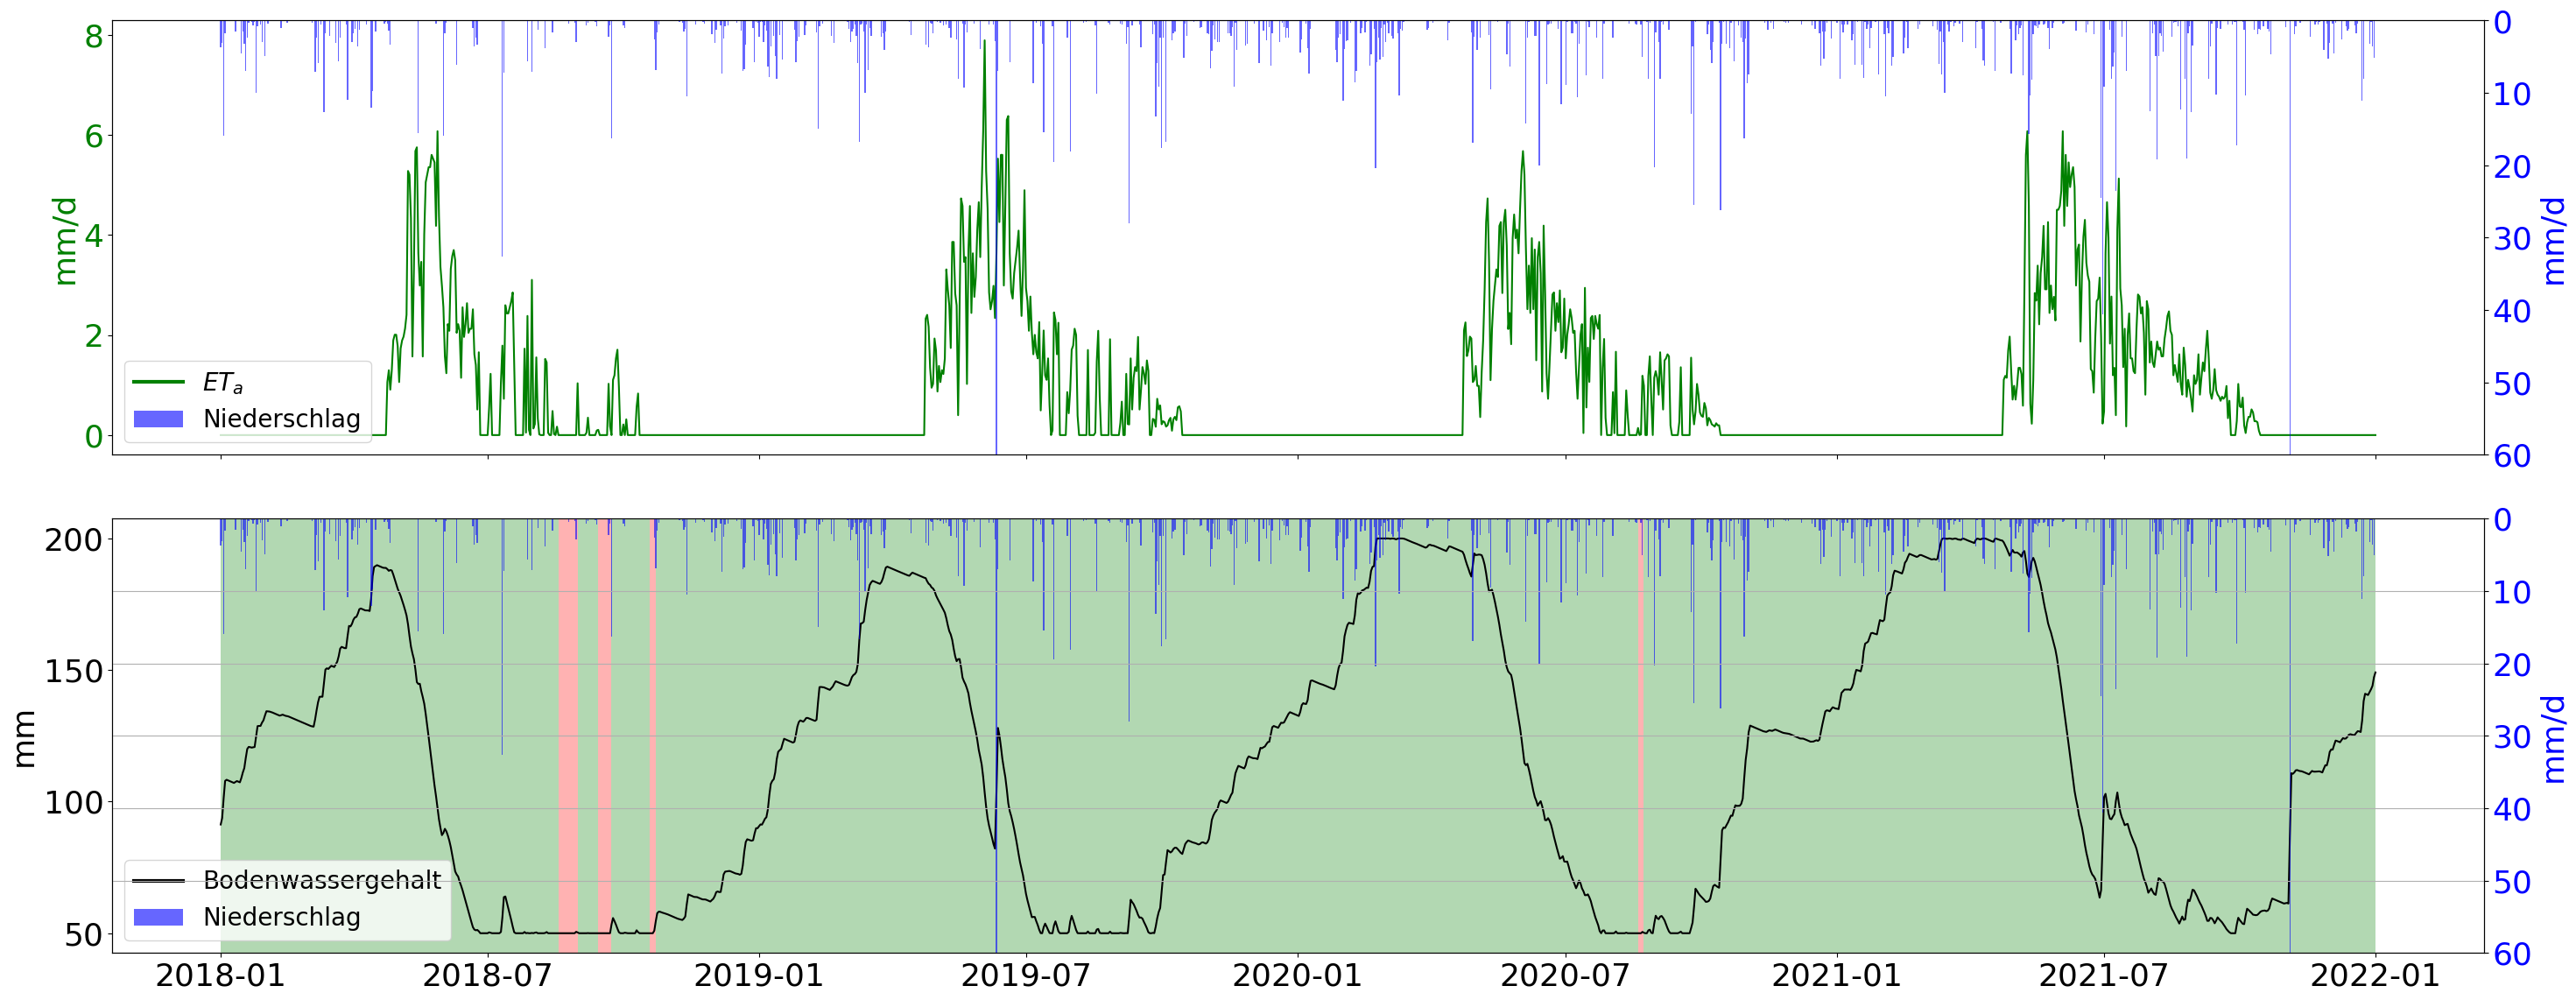

In [5]:
df = ut.urban_tree(data.et_pot.values, data.rain_corrected.values, data.date.values,
                       l_max=10,
                       c_i=0.5,
                       c_r=0.2,
                       c_rt=10,
                       c_inf=21,
                       k_c=0.64,
                       k_ea=0.54,
                       k_s=0.3,
                       fc=200,
                       pwp=50,
                       crown_area=40,
                       surface_sealing=0.1,
                       sealing_class=4,
                       rooting_depth=1.25,
                       start_water_content=0.45,
                       cistern_volume=155,
                       cistern_catchment=9.4,
                       loss_factor_in=0.4,
                       loss_factor_out=0.2,
                       irrigation_rate=90,
                       sky_view_factor=1.34)

df.set_index("date", inplace=True)
daily_summed = df.resample('D').sum()
daily_mean = df.resample("D").mean()

et_a_daily = df.et_a_mm.resample("D").sum()
rain_daily = df.rain_mm.resample("D").sum()
swc_daily = df["soil_water_content_mm/m"].resample("D").mean()
water_stress_daily = df.water_stress.resample("D").sum().round(0)

trockentage = len(water_stress_daily.loc[water_stress_daily > 12])
print(f'Jährliches Mittel der Tage mit Trockenstress: {round(trockentage/6, 1)} Tage/Jahr')

plot_df = pd.DataFrame({"rain":rain_daily, "et_a":et_a_daily, "soil_water_content":swc_daily,
                        "water_stress": water_stress_daily, "date":rain_daily.index})
ut.make_figure(plot_df)


## Optimierung von Zisterngröße und -auffangfläche

In diesem Schritt wird gezeigt, wie die optimale Kombination aus Zisternengröße und -auffangfläche um Tage mit Wasserstress zu vermeiden, ermittelt werden kann. Je höher der Wert der Iteration für die Optimierung gesetzt wird, umso länger dauert die Berechnung. Die Qualität der Ergebnisses nimmt mit der Anzahl der Iterationen zu.

In [6]:
def scale_params(x, bounds):
    return [(x[i] - bounds[i][0]) / (bounds[i][1] - bounds[i][0])
            for i in range(len(x))]


def unscale_params(x_scaled, bounds):
    return [
        bounds[i][0] + x_scaled[i] * (bounds[i][1] - bounds[i][0])
        for i in range(len(x_scaled))
    ]


def scaled_objective(x_scaled):
    x = unscale_params(x_scaled, bounds)
    return calibrate_model(x)


def calibrate_model(parameters):

    #print("Running Model")
    cistern_size, cistern_catchment = parameters

    base = cistern_size / 2000 + cistern_catchment / 200

    df = ut.urban_tree(data.et_pot.values,
                       data.rain_corrected.values,
                       data.date.values,
                       l_max=10,
                       c_i=0.5,
                       c_r=0.2,
                       c_rt=10,
                       c_inf=21,
                       k_c=0.64,
                       k_ea=0.54,
                       k_s=0.3,
                       fc=200,
                       pwp=50,
                       crown_area=40,
                       surface_sealing=0.1,
                       sealing_class=4,
                       rooting_depth=1.25,
                       start_water_content=0.45,
                       cistern_volume=cistern_size,
                       cistern_catchment=cistern_catchment,
                       loss_factor_in=0.4,
                       loss_factor_out=0.2,
                       irrigation_rate=90,
                       sky_view_factor=1.34)

    df.set_index("date", inplace=True)

    water_stress_daily = df.water_stress.resample("d").sum().round(0)
    days_water_stress = water_stress_daily[water_stress_daily > 12]

    penalty = 1000 * len(days_water_stress)

    print(f"Penalty: {base + penalty}, Size: {cistern_size}, Area: {cistern_catchment}")
    return base + penalty #the final penalty weighs the occurence of water stress days much higher, than the size of the cistern


#changed for just old trees
initial_values = np.array([200, 8])
bounds = [(50, 2000), (2, 100)]


def main():

    # Create an initial simplex with larger steps

    scaled_x0 = scale_params(initial_values, bounds)

    initial_simplex = np.array([
        np.array(scaled_x0),
        np.array(scaled_x0) +
        [0.03, 0.0],  # here we can adjust how far the steps are in the beginning
        np.array(scaled_x0) + [0.0, 0.05],  # we have to keep in mind, that the parameter space is between 0-1
    ])

    opti_res = scipy.optimize.minimize(scaled_objective,
                                       x0=scaled_x0,
                                       bounds=[(0, 1), (0, 1)],
                                       method="Nelder-Mead",
                                       options={
                                           'maxfev': 30,
                                           'initial_simplex': initial_simplex
                                       })

    # Unscale the result
    best_parameters = unscale_params(opti_res.x, bounds)

    res_df = {
        "water_stress_days": opti_res.fun // 1000,
        "cistern_volume": np.round(best_parameters[0], 0),
        "cistern_catchment": np.round(best_parameters[1], 0),
    }

    return res_df, opti_res

optimization_df, optimization_result = main()

print("###########################")
print("# Optimierungsergebnis")
print(f"Anzahl der Wasserstresstage (2018-2024): {optimization_df['water_stress_days']/ 7}")
print(f"Beste Lösung Zisternenvolumen: {optimization_df['cistern_volume']} l")
print(f"Beste Lösung Zisternenauffangfläche: {optimization_df['cistern_catchment']} m²")
print("Abbruch der Optimierung:", optimization_result.message)
print("Anzahl der Iterationen:", optimization_result.nit)

Penalty: 25000.14, Size: 200.0, Area: 8.0
Penalty: 24000.16925, Size: 258.5, Area: 8.0
Penalty: 12000.1645, Size: 200.0, Area: 12.9
Penalty: 8000.19375, Size: 258.5, Area: 12.900000000000002
Penalty: 8000.220625, Size: 287.75, Area: 15.350000000000005
Penalty: 12000.189, Size: 200.0, Area: 17.799999999999997
Penalty: 12000.1840625, Size: 214.625, Area: 15.35
Penalty: 13000.1741875, Size: 243.87500000000003, Area: 10.450000000000001
Penalty: 12000.18159375, Size: 221.9375, Area: 14.125
Penalty: 12000.17665625, Size: 236.5625, Area: 11.675
Penalty: 12000.177890625, Size: 232.90625, Area: 12.2875
Penalty: 12000.179125, Size: 229.25, Area: 12.9
Penalty: 8000.187671875, Size: 240.21875000000003, Area: 13.512500000000001
Penalty: 8000.202296875, Size: 269.46875, Area: 13.512500000000003
Penalty: 8000.19650390625, Size: 259.4140625, Area: 13.359375000000002
Penalty: 8000.18491796875, Size: 239.30468750000003, Area: 13.053125000000001
Penalty: 12000.179125, Size: 229.25000000000003, Area: 12.9

Hier findet die Optimierung ein größeres Zisternenvolumen und eine größere Zisternenauffangfläche, um die Anzahl der Wasserstresstage weiter zu verringern. Ohne Bewässerung kommt es an 23,2 Tagen/Jahr zu Trockenstress. Mit den Standard-Zisternenkennwerten für mittelalte Bäume (Größe 155l, Auffangfläche 9.4 m²) kommt es zu 4,5 Trockenstresstagen/Jahr. Mit individueller Optimierung kann dieser Wert auf 1.1 Trockenstresstage/Jahr minimiert werden, wozu ein Zisternenvolumen von 232 l und eine Auffangfläche von 13 m² benötigt wird.

In diesem Fall hätte die Optimierung evt. zu einem besseren Ergebnis bei höherer Anzahl der "Function evaluations" in scipy.optimize.minimize (Parameter "maxfev") führen können.